# Question 1

According to the vasp wiki:
- ENCUT specifies the cutoff energy for the plane-wave-basis set in eV.
- EDIFF specifies the global break condition for the electronic SC-loop. EDIFF is specified in units of eV. 

These two parameters are important in order to define limits of the simulations

# Question 2

```
  3.9
```
This line provides a universal scaling factor (lattice constant), which is used to scale all lattice vectors and all atomic coordinates (of this value is negative it is interpreted as the total volume of the cell)

```
0.5 0.5 0.0
0.0 0.5 0.5
0.5 0.0 0.5
```
On these lines, the three lattice vectors defining the unit cell of the system are given (first line corresponding to the first lattice vector, second to the second, and third to the third)

# Question 3

By looking at the end of the OUTCAR file, we can see:
```
CPU time  : 0.0020 (s)\
Real time : 0.0027 (s)
```
This is really quick but the system is very basic so that makes sens.

# Question 4

By using the `grep 'TOTEN' OUTCAR` command, we get the total energy, which is here -4.86 eV

For now I don't have any point of comparison so I cannot say anything about it.

# Question 5

```bash
#!/bin/bash
#$ -V
#$ -N Silicon_cutoff_opt
#$ -cwd
#$ -o $JOB_NAME.o$JOB_ID
#$ -e my_stderr
#$ -pe mpi 16
#$ -l h_vmem=4G
#$ -q  parallel.q
#$ -M noah.perreau@univ-fcomte.fr
#$ -m bea

module load vasp/5.4  
rm energy.txt         # remove old results
mkdir -p outputs      # creating output folder

# execute for all the following values as the CUTOFF
for cutoff in 100 110 120 130 140 150 160 170 180 190 200 220 240 260 280 300 350 400 450 500
do
        # get the INCAR_template content, replace the CUTOFF value and place the result in the INCAR file
        sed -e "s/MY_ENCUT/${cutoff}/g" INCAR_template > INCAR
        # start the computations
        mpirun -np $NSLOTS vasp
        # get the last line of the OSZICAR file and keep only the caracters 27 to 42
        energy=$(tail -n 1 OSZICAR | cut -b27-42)
        # save the energy according and CUTOFF used at the end of the energy.txt file
        printf "%5d  " $cutoff >> energy.txt
        echo $energy >> energy.txt

        # save the generated files for each cutoff value
        mv OSZICAR outputs/OSZICAR_$cutoff
        mv OUTCAR outputs/OUTCAR_$cutoff
done
```

In short : the script compute and save the total energy for different cutoff values step in a file "energy.txt".

# Question 6

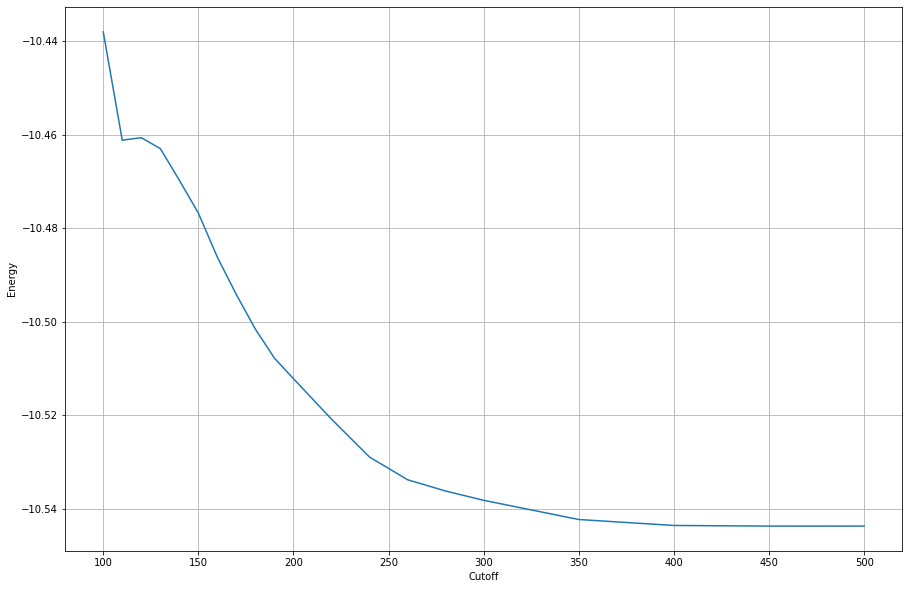

In [1]:
from numpy import *
import matplotlib.pyplot as plt

data = loadtxt('results/Q6_energy.txt')

plt.figure(figsize=[15,10])
plt.plot(data[:,0],data[:,1])
plt.xlabel('Cutoff')
plt.ylabel('Energy')
plt.grid()
plt.show()

According to this graph, the energy seems to converge above 400

# Question 7

number of bands: 16
number of k-points: 600
is metal: True
is spin polarized: False
Fermi energy: 9.49328909
band gap: {'energy': 0.0, 'direct': False, 'transition': None}


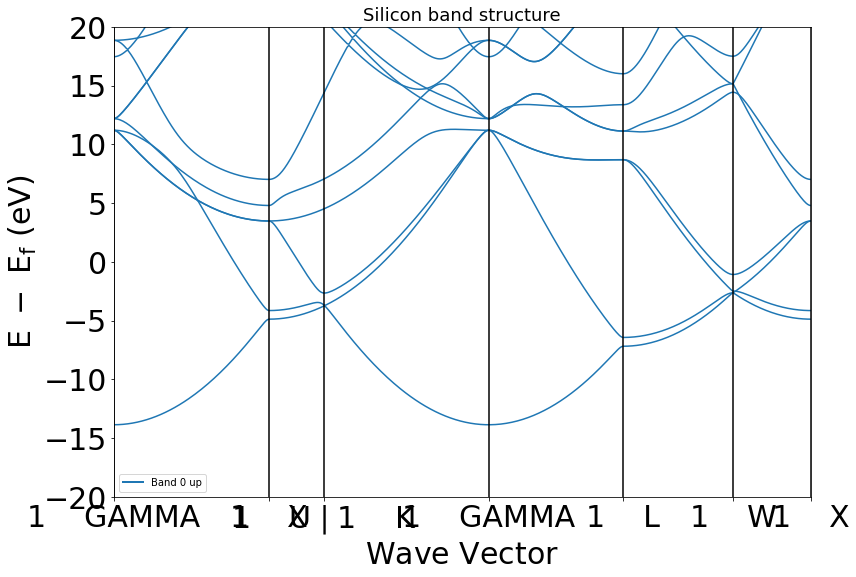

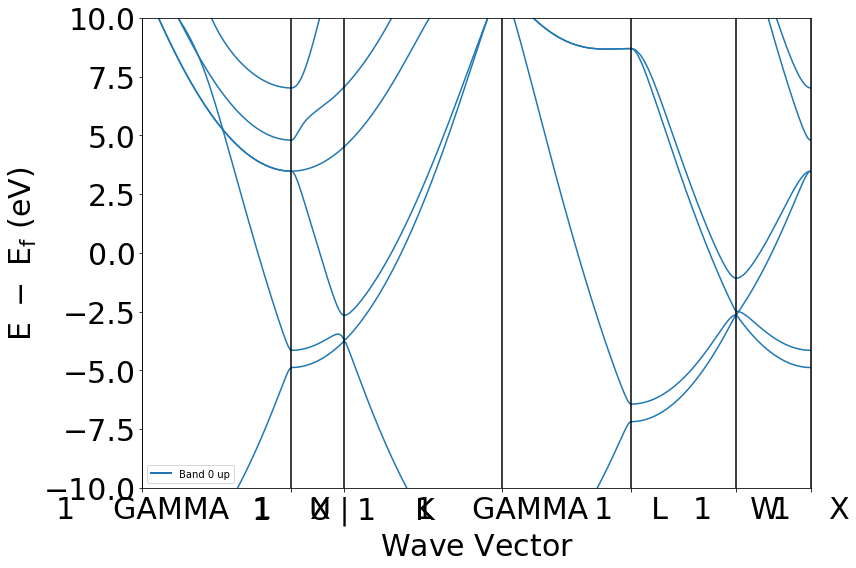

In [2]:
import pymatgen.core as mg
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
from pymatgen.electronic_structure.core import Spin
from pymatgen.electronic_structure.plotter import BSPlotter, BSDOSPlotter, DosPlotter

import matplotlib.pyplot as plt

def print_bands (bs):
	for kpoint, band in zip (bs.kpoints, bs.bands [Spin.up]):
		kx = kpoint.frac_coords [0]
		ky = kpoint.frac_coords [1]
		kz = kpoint.frac_coords [2]
		for energy in band:
			print ("k = [{:+.3f} {:+.3f} {:+.3f}]    E(k) = {:+.6e}".format (kx, ky, kz, energy))


def plot_bands(vasprum_file, KPOINT_file):
	run = BSVasprun (vasprum_file, parse_projected_eigen = True)
	bs = run.get_band_structure (KPOINT_file)

	print ("number of bands:", bs.nb_bands)
	print ("number of k-points:", len (bs.kpoints))
	print ("is metal:", bs.is_metal ())
	print ("is spin polarized:", bs.is_spin_polarized)
	print ("Fermi energy:", bs.efermi)

	print ("band gap: {}".format (bs.get_band_gap ()))

	bsplot = BSPlotter (bs)
	bsplot.get_plot (ylim = (-20, 20), zero_to_efermi = True)
	ax = plt.gca ()
	ax.set_title ("Silicon band structure", fontsize = 18)

	ax.plot (label = "spin up")
	bsplot.show ()

plot_bands("results/Q7_vasprun.xml","results/Q7_KPOINTS")

According to my friend Google, the band structure of the Sillicium is this one:

<img src="img/Q7.png" style="width:400px">

We can see that there is some differences between the computed results and the expected one. In particular, we can see that we expect a band gap that we don't have in the computed results. The FCC structure is then a conductor whil the real Silicium is a semi-conductor.

# Question 8

Previously, we had:
```
FCC Silicon
 3.9
0.5 0.5 0.0
0.0 0.5 0.5
0.5 0.0 0.5
  1
cartesian
  0 0 0
```
Now, we have 
```
Real silicon (diamond-like)
 5.5
0.0 0.5 0.5
0.5 0.0 0.5
0.5 0.5 0.0
  2
Direct
  -0.125 -0.125 -0.125
  +0.125 +0.125 +0.125
```
The lattice constant has increased and the lattice vectors changed. In particular, we can see that we now use the "direct" vectors, which correspond to the position of the atoms using the base formed by the vectors of the lattice.

# Question 9

What changed :
```
SYSTEM = FCC Silicon
ISTART = 0
ICHARG = 2
LREAL = .FALSE.
```
becomes:
```
SYSTEM = Real silicon (diamond-like)
IBRION = 2
ISIF = 3
NSW = 20
EDIFFG = -1e-4
```
`IBRION` parameter set to 2 allow to use the conjugate gradient algorithm\
`ISIF` allow to compute the forces and the stress tensor for cells with all the possible degree of liberty (positions, cell shape and cell volume)

# Question 10

Using the command `grep 'Iteration' OUTCAR` and lookink at the last printed line, we see that the programme does 4 ioninc steps before reaching the ioninc vonergeance criteria.

# Question 11

For the FCC Silicon, we had `TOTEN = -5.35 eV`. Now, we have `TOTEN = -10.85 eV`. The energy is then lower so it makes a better candidate because the energy is minimized.


# Question 12

Looking at the OUTCAR file, the new vector lenghts are:
```
0.000000000  2.734294171  2.734294171
2.734294171  0.000000000  2.734294171
2.734294171  2.734294171  0.000000000
```
The cell volume is now 40.89

# Question 13

number of bands: 16
number of k-points: 600
is metal: False
is spin polarized: False
Fermi energy: 6.03009504
band gap: {'direct': False, 'energy': 0.5530999999999997, 'transition': '1    GAMMA-(0.419,0.000,0.419)'}


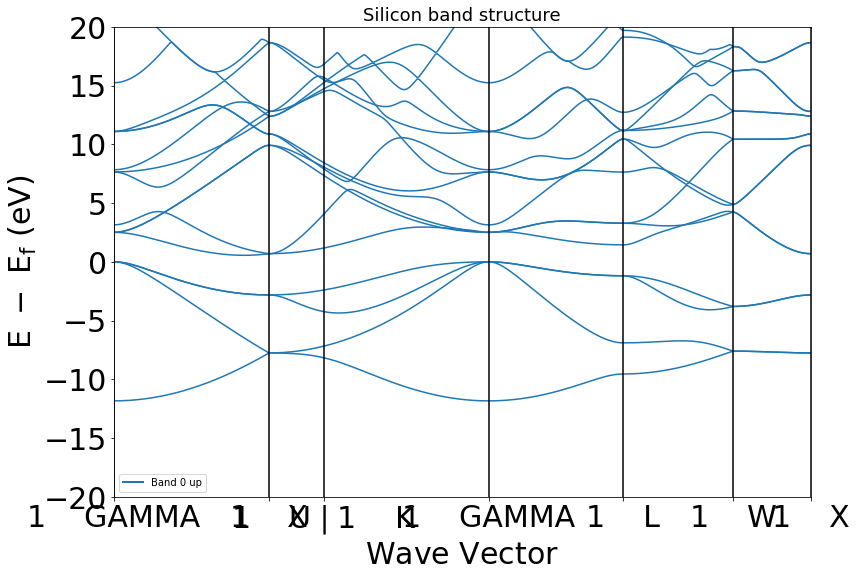

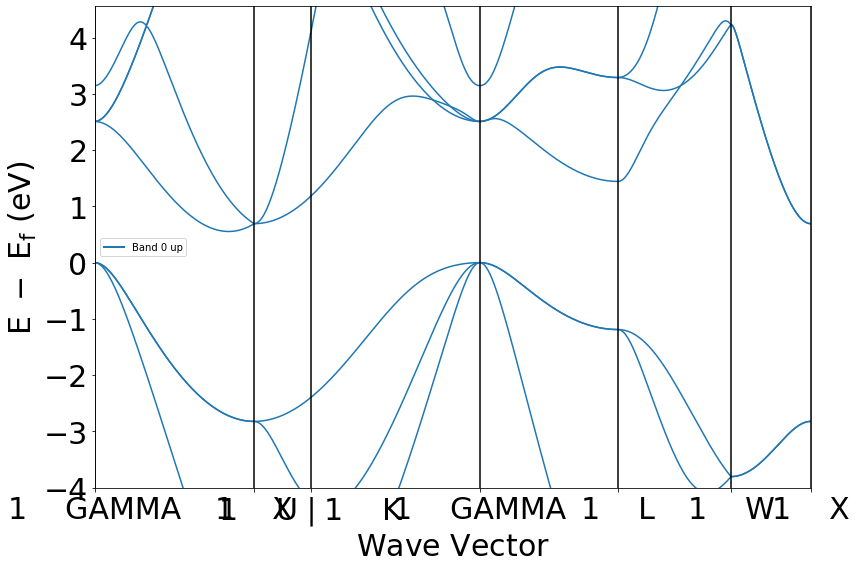

In [5]:
plot_bands("results/Q13_vasprun.xml", "results/Q13_KPOINTS")

Now we have the band gap of 0.55 eV!

<img src="img/Q7.png" style="width:400px">

The band structure looks now more similar to the exepected result. As the room temperature energy is about 0.02 eV, this band structure represent at least a semi-conductor, maybe an insolator (depending on where we put the limit)

# Question 14

Previously, we had

```
Real silicon (diamond-like)
 5.5
0.0 0.5 0.5
0.5 0.0 0.5
0.5 0.5 0.0
  2
Direct
  -0.125 -0.125 -0.125
  +0.125 +0.125 +0.125
```

And now:
```
Diamond
 3.567
0.5 0.5 0.0
0.0 0.5 0.5
0.5 0.0 0.5
 2
direct
0.0 0.0 0.0
0.25 0.25 0.25
```
The size and lattice vectors are different.

The POTCAR file have also different values. We can see that it well use Carbone instead of Sillicium

<img src="img/Q13.png" style="width:1200px">

# Question 15

The new energy is `TOTEN = -15.69077604 eV`, so even less than the previous ones.

With the carbon diamond, we have
```
volume of cell :       12.11
direct lattice vectors :
     1.822650248  1.822650248  0.000000000
     0.000000000  1.822650248  1.822650248
     1.822650248 -0.000000000  1.822650248
```
We see that the volume increased a bit during the optimization.

# Question 16

number of bands: 16
number of k-points: 600
is metal: False
is spin polarized: False
Fermi energy: 9.50304459
band gap: {'direct': False, 'energy': 3.9015000000000004, 'transition': '1    GAMMA-(0.364,0.000,0.364)'}


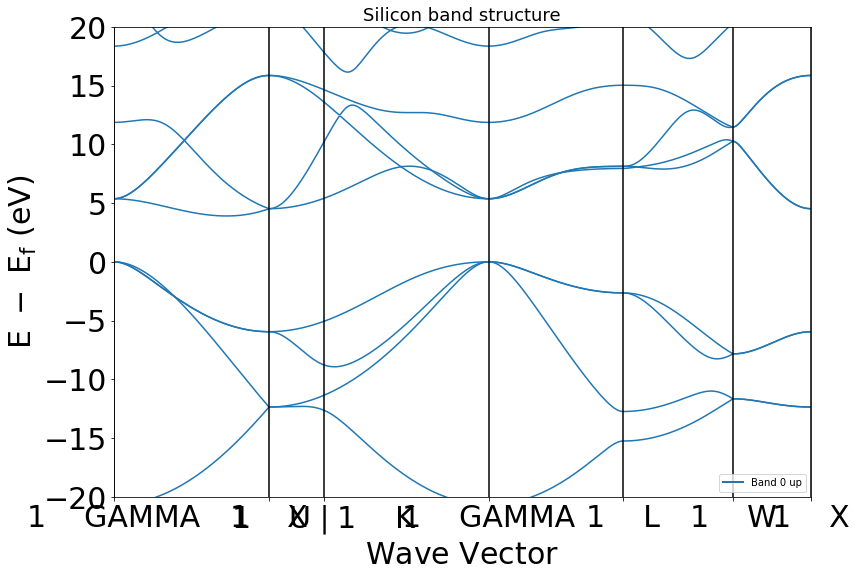

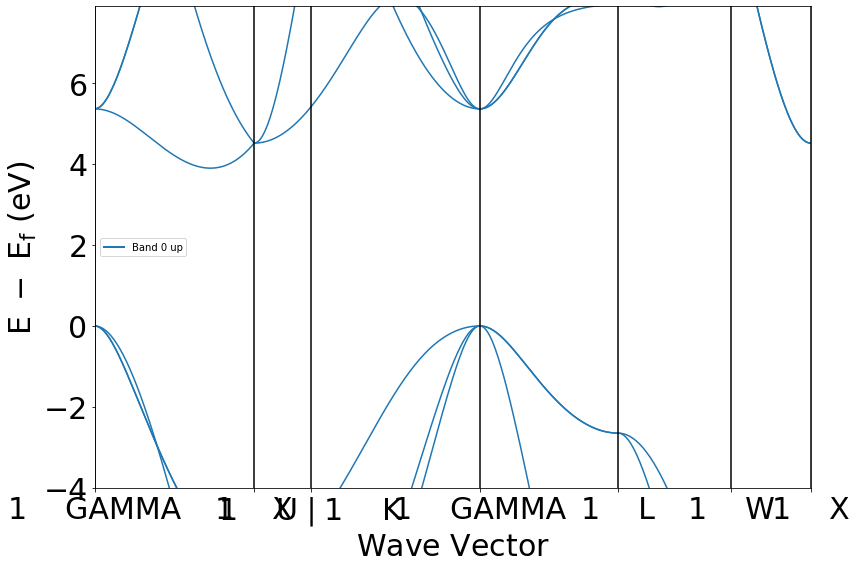

In [4]:
plot_bands("results/Q16_vasprun.xml", "results/Q16_KPOINTS")

Now we have a huge band gap, so this is an insulator. The program gives us a band gap of 3.9 eV